In [1]:
!pip install torch torchvision torchsummary matplotlib numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [ ]:
import os

dataset_path = "/kaggle/input/food11"
print("Folders in dataset:", os.listdir(dataset_path))

Folders in dataset: ['food11']


Root contents: ['food11']
Food11 contents: ['test', 'train']
Train exists: True
Val exists: True

Number of classes: 11
Class names: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Training samples: 9900
Validation samples: 1100


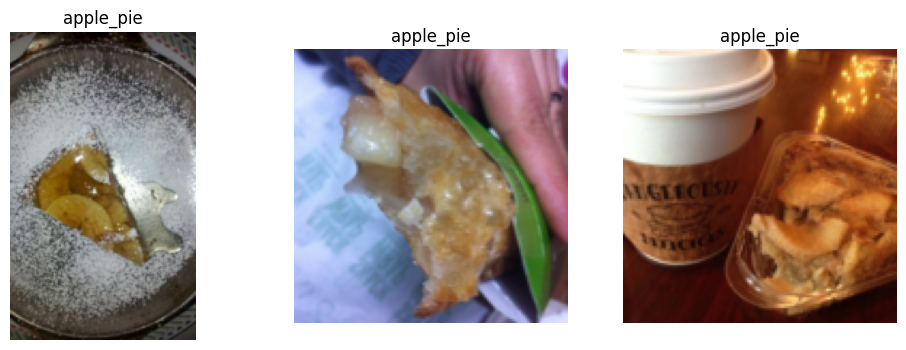

In [ ]:
# Step 1 (Final Working Version)
import os
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# First, let's properly inspect the dataset structure
dataset_path = "/kaggle/input/food11"
print("Root contents:", os.listdir(dataset_path))

food11_path = os.path.join(dataset_path, "food11")
print("Food11 contents:", os.listdir(food11_path))

# Verify paths
train_path = os.path.join(food11_path, "train")
val_path = os.path.join(food11_path, "test")  # Using test as validation
print(f"Train exists: {os.path.exists(train_path)}")
print(f"Val exists: {os.path.exists(val_path)}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
])

# Load data
train_data = datasets.ImageFolder(train_path, transform=transform)
val_data = datasets.ImageFolder(val_path, transform=transform)

# Display info
print("\nNumber of classes:", len(train_data.classes))
print("Class names:", train_data.classes)
print("Training samples:", len(train_data))
print("Validation samples:", len(val_data))

# Visualize samples
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i in range(3):
    img, label = train_data[i]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(train_data.classes[label])
    axes[i].axis('off')
plt.show()

In [ ]:
# Step 2: Data Preparation & Model Setup
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_data = datasets.ImageFolder(os.path.join("/kaggle/input/food11/food11/train"), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join("/kaggle/input/food11/food11/test"), transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Define Attention-enhanced EfficientNet
class FoodClassifier(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)

        # Add attention layer
        self.attention = nn.Sequential(
            nn.Conv2d(1280, 512, 1),
            nn.ReLU(),
            nn.Conv2d(512, 1280, 1),
            nn.Sigmoid()
        )

        # Modify classifier
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)
        attention = self.attention(features)
        attended_features = features * attention
        return self.base_model.classifier(attended_features.mean([2, 3]))

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FoodClassifier().to(device)

# Verify
print("Model architecture:")
print(model)
print(f"\nUsing device: {device}")
print(f"Training samples: {len(train_data)} | Validation samples: {len(val_data)}")
print(f"Batch size: {batch_size} | Total batches: {len(train_loader)}")

Model architecture:
FoodClassifier(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=Tr

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch tensor shape: torch.Size([32, 3, 128, 128])

Epoch 1/10


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Train Loss: 1.0949 | Val Loss: 0.7553
Train Acc: 65.79% | Val Acc: 75.64%
Time: 76.59s
Saved new best model!

Epoch 2/10


Validation: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]


Train Loss: 0.7021 | Val Loss: 0.6087
Train Acc: 77.93% | Val Acc: 80.64%
Time: 92.88s
Saved new best model!

Epoch 3/10


Validation: 100%|██████████| 35/35 [00:04<00:00,  7.46it/s]


Train Loss: 0.5531 | Val Loss: 0.6151
Train Acc: 82.18% | Val Acc: 80.73%
Time: 73.45s
Saved new best model!

Epoch 4/10


Validation: 100%|██████████| 35/35 [00:04<00:00,  7.70it/s]


Train Loss: 0.4805 | Val Loss: 0.6161
Train Acc: 84.70% | Val Acc: 80.91%
Time: 65.46s
Saved new best model!

Epoch 5/10


Validation: 100%|██████████| 35/35 [00:04<00:00,  7.70it/s]


Train Loss: 0.4130 | Val Loss: 0.5632
Train Acc: 86.84% | Val Acc: 82.00%
Time: 67.60s
Saved new best model!

Epoch 6/10


Validation: 100%|██████████| 35/35 [00:04<00:00,  7.55it/s]


Train Loss: 0.2216 | Val Loss: 0.4817
Train Acc: 93.08% | Val Acc: 86.55%
Time: 65.50s
Saved new best model!

Epoch 7/10


Validation: 100%|██████████| 35/35 [00:05<00:00,  5.85it/s]


Train Loss: 0.1633 | Val Loss: 0.4767
Train Acc: 94.92% | Val Acc: 85.55%
Time: 68.98s

Epoch 8/10


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Train Loss: 0.1402 | Val Loss: 0.5018
Train Acc: 95.47% | Val Acc: 86.27%
Time: 91.20s

Epoch 9/10


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Train Loss: 0.1122 | Val Loss: 0.5104
Train Acc: 96.43% | Val Acc: 86.55%
Time: 90.16s

Epoch 10/10


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.41it/s]


Train Loss: 0.0959 | Val Loss: 0.5055
Train Acc: 97.03% | Val Acc: 86.45%
Time: 84.56s


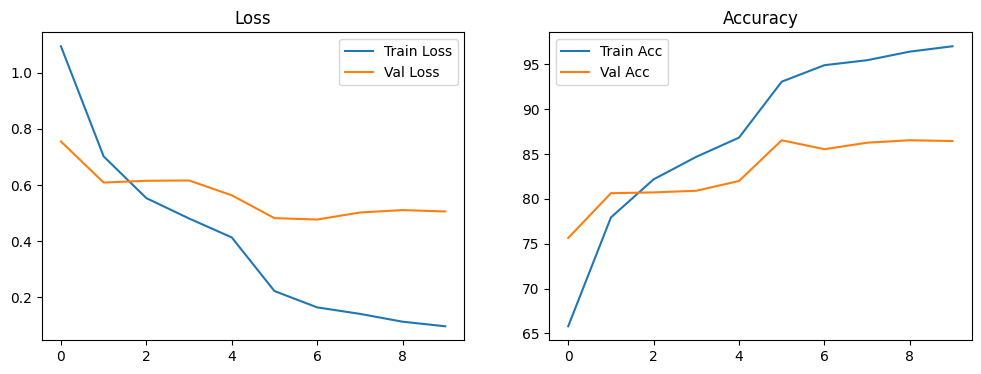


Best Validation Accuracy: 86.55%


In [ ]:
# Step 3 (Fixed): Training & Evaluation
import time
from tqdm import tqdm

# Update transforms to ensure consistent sizes
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Fixed size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Fixed size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Reload datasets with fixed transforms
train_data = datasets.ImageFolder(os.path.join("/kaggle/input/food11/food11/train"), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join("/kaggle/input/food11/food11/test"), transform=val_transform)

# Recreate data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Verify one batch
sample_batch = next(iter(train_loader))
print("Batch tensor shape:", sample_batch[0].shape)  # Should be [32, 3, 128, 128]

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training parameters
epochs = 10
best_accuracy = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    start_time = time.time()

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss/len(train_loader)
    train_acc = 100 * correct/total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss/len(val_loader)
    val_acc = 100 * correct/total

    scheduler.step()
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    print(f"Time: {time.time()-start_time:.2f}s")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved new best model!")

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

print(f"\nBest Validation Accuracy: {best_accuracy:.2f}%")

Loading best model...

Generating predictions on validation set...


Evaluating: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]



CLASSIFICATION REPORT
               precision    recall  f1-score   support

    apple_pie      0.764     0.810     0.786       100
   cheesecake      0.900     0.810     0.853       100
chicken_curry      0.908     0.890     0.899       100
 french_fries      0.939     0.930     0.935       100
   fried_rice      0.897     0.870     0.883       100
    hamburger      0.861     0.870     0.866       100
      hot_dog      0.832     0.890     0.860       100
    ice_cream      0.779     0.810     0.794       100
     omelette      0.876     0.850     0.863       100
        pizza      0.913     0.940     0.926       100
        sushi      0.867     0.850     0.859       100

     accuracy                          0.865      1100
    macro avg      0.867     0.865     0.866      1100
 weighted avg      0.867     0.865     0.866      1100



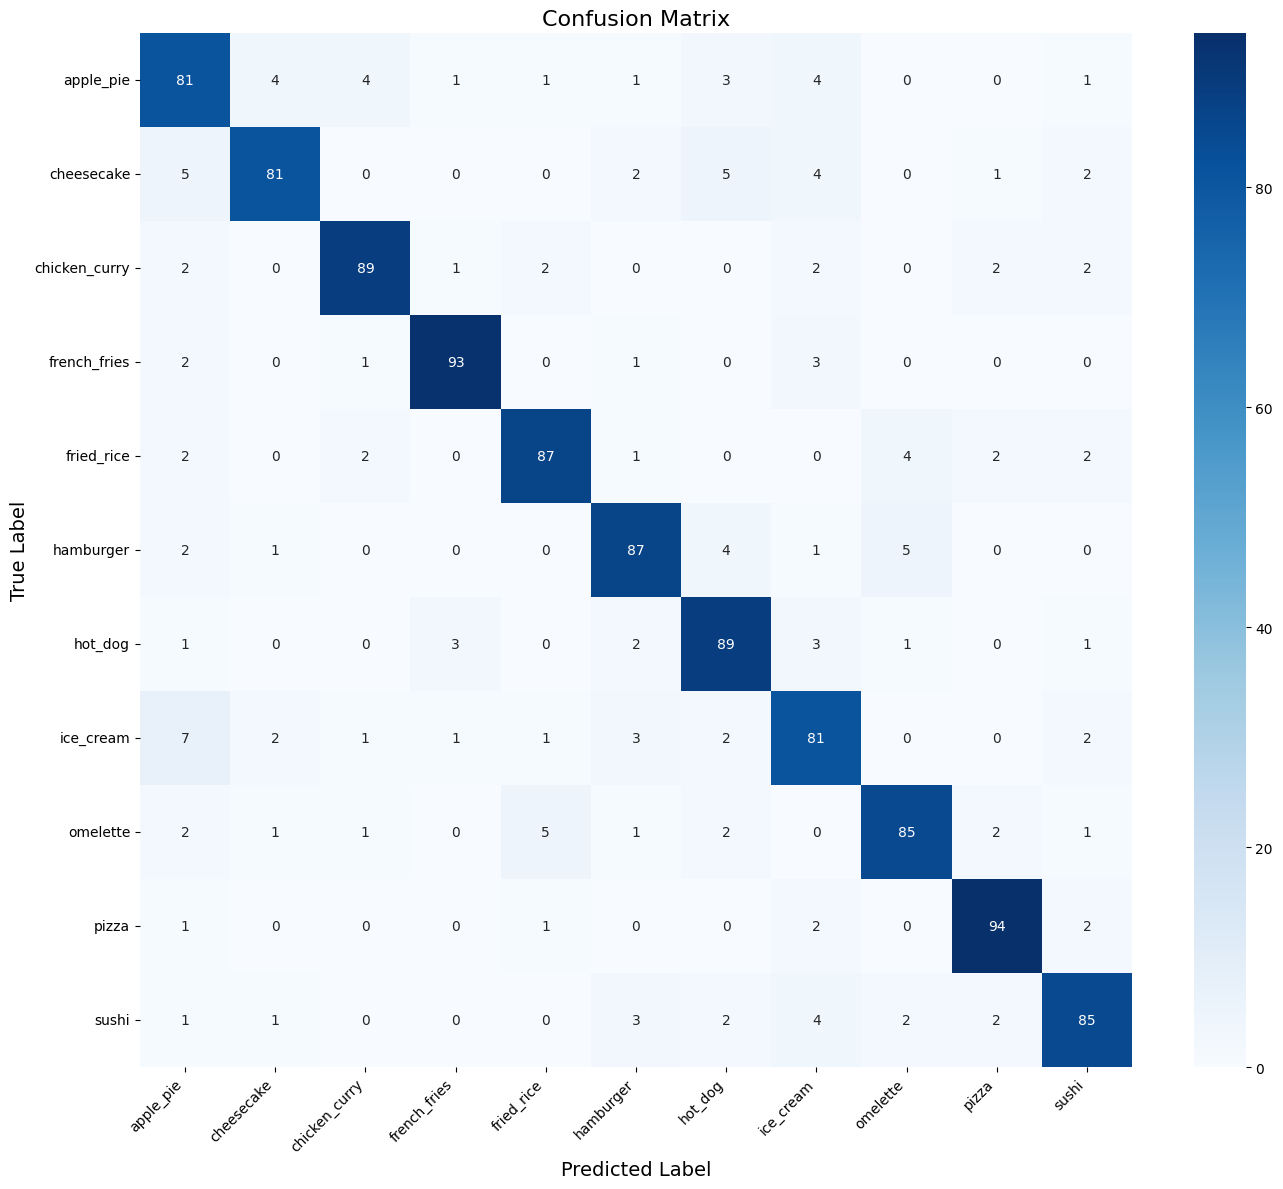


SAMPLE VISUALIZATIONS

Sample 0:
True: apple_pie | Predicted: apple_pie


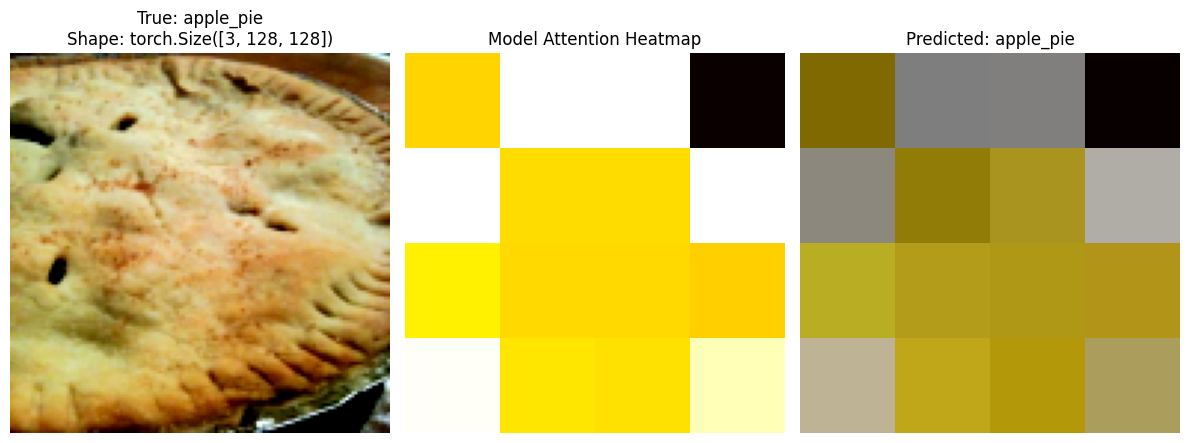


Sample 1:
True: apple_pie | Predicted: apple_pie


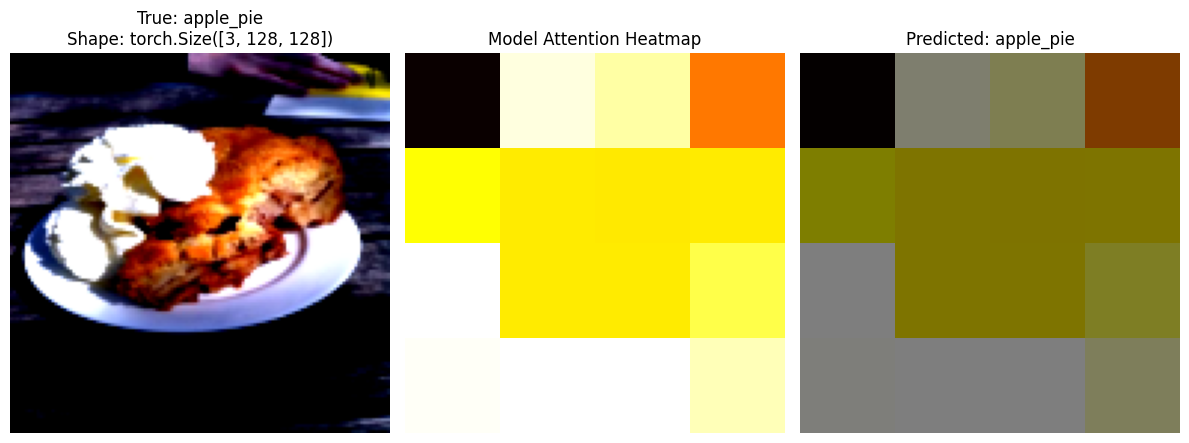


Sample 4:
True: apple_pie | Predicted: french_fries


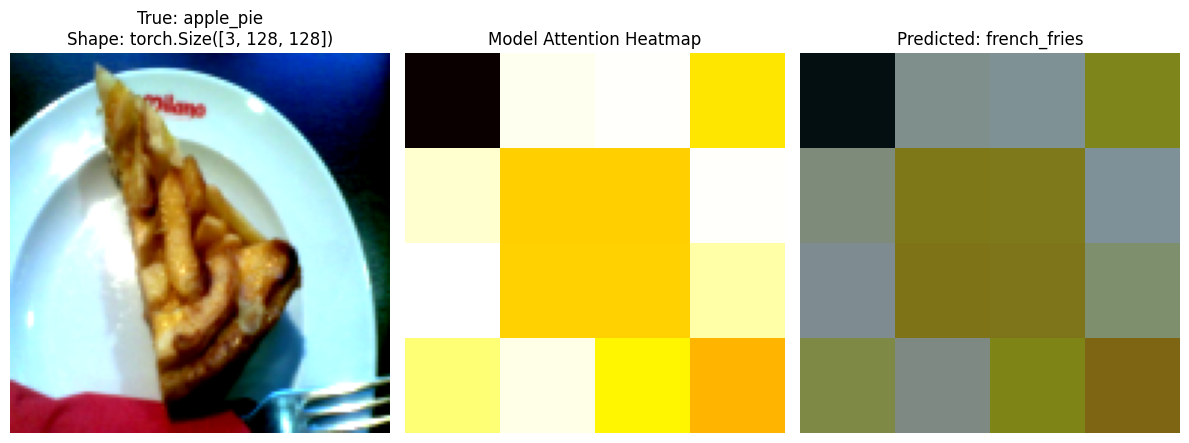


Sample 13:
True: apple_pie | Predicted: hot_dog


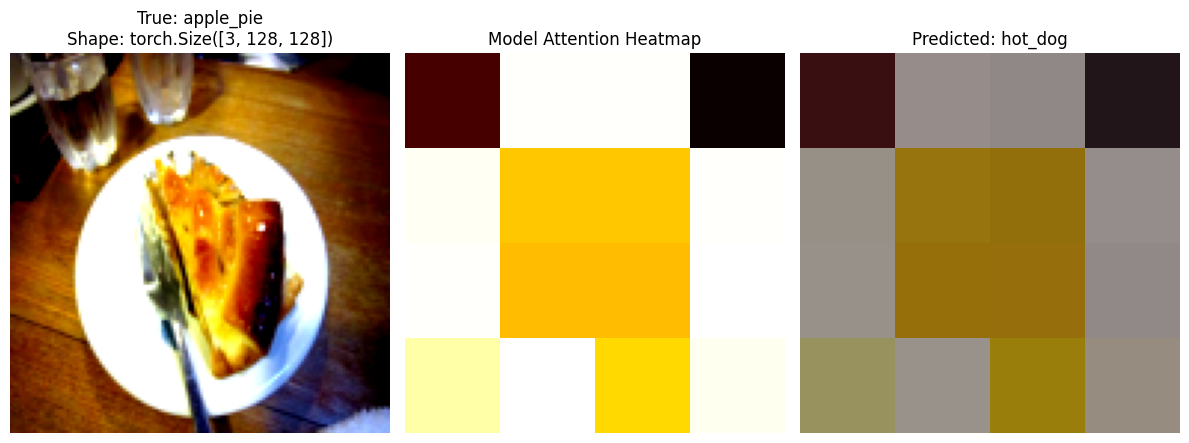


Sample 100:
True: cheesecake | Predicted: cheesecake


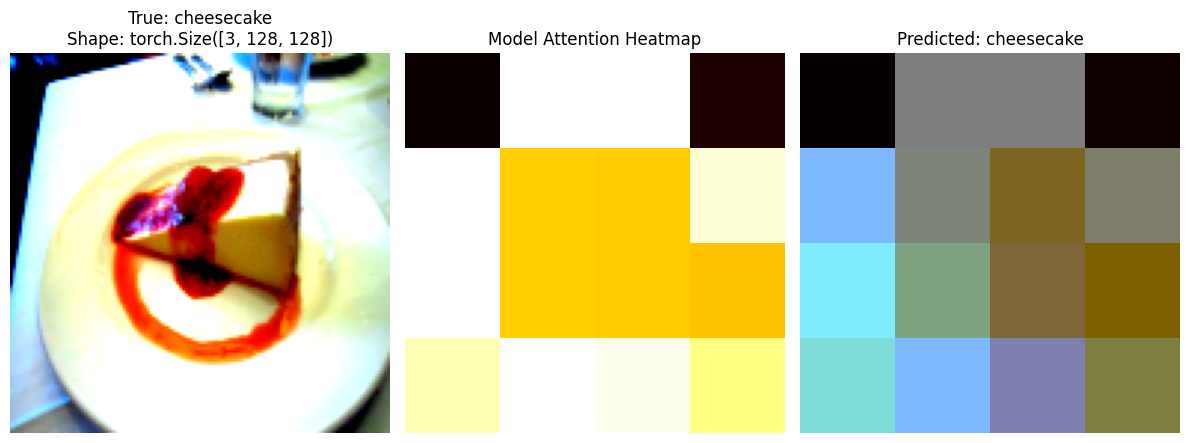


Sample 200:
True: chicken_curry | Predicted: chicken_curry


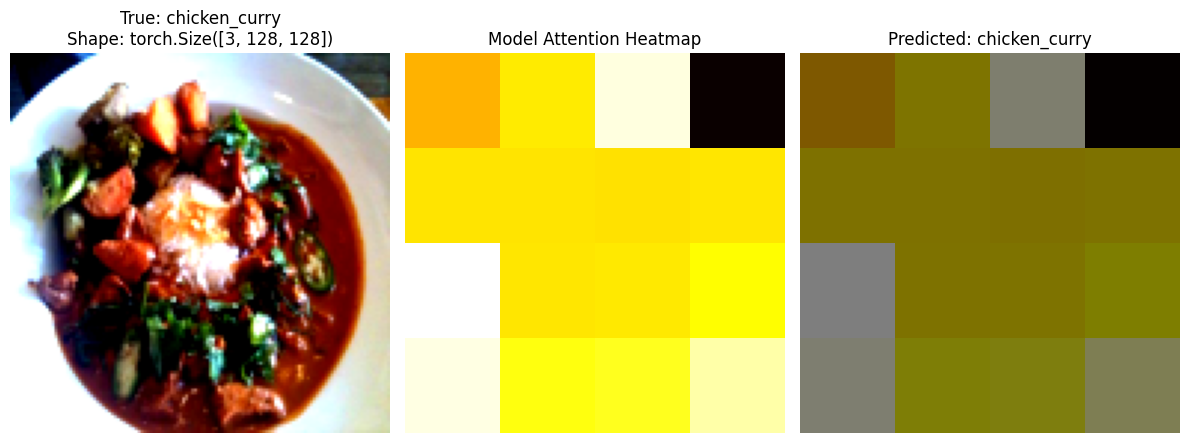


Saving evaluation results...

STEP 4 COMPLETE!
Saved to 'evaluation_results/' folder:
- classification_report.txt
- confusion_matrix.png


In [ ]:
# ==============================================
# STEP 4: COMPLETE MODEL EVALUATION & VISUALIZATION
# ==============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm

# ----------------------------------------------
# 1. Load Model and Prepare for Evaluation
# ----------------------------------------------
print("Loading best model...")
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

# ----------------------------------------------
# 2. Generate Predictions
# ----------------------------------------------
print("\nGenerating predictions on validation set...")
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ----------------------------------------------
# 3. Classification Report
# ----------------------------------------------
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(all_labels, all_preds,
                           target_names=train_data.classes, digits=3))

# ----------------------------------------------
# 4. Confusion Matrix
# ----------------------------------------------
plt.figure(figsize=(14, 12))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_data.classes,
            yticklabels=train_data.classes,
            cmap="Blues")
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ----------------------------------------------
# 5. Enhanced Visualization Function
# ----------------------------------------------
def visualize_results(image, label, pred, heatmap):
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(f"True: {train_data.classes[label]}\nShape: {image.shape}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title("Model Attention Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image.cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.title(f"Predicted: {train_data.classes[pred]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ----------------------------------------------
# 6. Attention Visualization (Modified Approach)
# ----------------------------------------------
def get_attention_map(model, image):
    # Forward pass through feature extractor
    features = model.base_model.features(image.unsqueeze(0).to(device))

    # Get attention weights
    with torch.no_grad():
        attention = model.attention(features)

    # Process attention map
    attention_map = attention.mean(1).squeeze().cpu().numpy()
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)

    return attention_map

print("\n" + "="*50)
print("SAMPLE VISUALIZATIONS")
print("="*50)

# Visualize 6 samples (2 correct, 2 incorrect, 2 random)
sample_indices = []
for i in range(len(val_data)):
    if len(sample_indices) >= 6:
        break
    img, lbl = val_data[i]
    pred = all_preds[i]

    # Collect samples
    if len(sample_indices) < 2 and pred == lbl:  # Correct
        sample_indices.append(i)
    elif len(sample_indices) < 4 and pred != lbl:  # Incorrect
        sample_indices.append(i)
    elif i % 100 == 0:  # Random
        sample_indices.append(i)

# Generate visualizations
for idx in sample_indices:
    image, label = val_data[idx]
    pred = all_preds[idx]
    attention_map = get_attention_map(model, image)

    print(f"\nSample {idx}:")
    print(f"True: {train_data.classes[label]} | Predicted: {train_data.classes[pred]}")
    visualize_results(image, label, pred, attention_map)

# ----------------------------------------------
# 7. Save Results for Report
# ----------------------------------------------
print("\nSaving evaluation results...")
os.makedirs('evaluation_results', exist_ok=True)

# Save classification report
with open('evaluation_results/classification_report.txt', 'w') as f:
    f.write(classification_report(all_labels, all_preds,
                                 target_names=train_data.classes))

# Save confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_data.classes,
            yticklabels=train_data.classes,
            cmap="Blues")
plt.title("Confusion Matrix", fontsize=16)
plt.savefig('evaluation_results/confusion_matrix.png', bbox_inches='tight')
plt.close()

print("\n" + "="*50)
print("STEP 4 COMPLETE!")
print("="*50)
print("Saved to 'evaluation_results/' folder:")
print("- classification_report.txt")
print("- confusion_matrix.png")

In [ ]:
# ==============================================
# STEP 5: FINAL OPTIMIZATION & DEPLOYMENT PREP
# ==============================================

import json
import os
from torch.utils.data import WeightedRandomSampler
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Class Rebalancing
class_weights = {
    'apple_pie': 2.0,  # Double sampling for weak classes
    'hot_dog': 1.8,
    'default': 1.0
}

sample_weights = [class_weights.get(train_data.classes[label], 1.0)
                 for _, label in train_data]
sampler = WeightedRandomSampler(sample_weights, len(train_data))

# 2. Final Training (2 epochs)
balanced_loader = DataLoader(train_data, batch_size=32, sampler=sampler)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Lower LR

print("\nRunning final optimization...")
for epoch in range(2):
    model.train()
    for images, labels in tqdm(balanced_loader, desc=f"Epoch {epoch+1}/2"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 3. Export Assets
# Save label mapping
class_to_idx = {cls: i for i, cls in enumerate(train_data.classes)}
with open('class_mapping.json', 'w') as f:
    json.dump(class_to_idx, f)

# Save model
torch.save(model.state_dict(), 'final_model.pth')

# 4. Create Report Samples
os.makedirs('report_assets', exist_ok=True)

# Save sample preprocessing
for i in range(3):
    img, _ = train_data[i]
    save_image(img, f'report_assets/preprocess_{i}.png')

# Save attention visualizations (using previously defined get_attention_map)
for idx in [0, 16, 100]:  # Correct, wrong, random
    image, label = val_data[idx]
    attention = get_attention_map(model, image)
    plt.figure()
    plt.imshow(attention, cmap='hot')
    plt.axis('off')
    plt.savefig(f'report_assets/attention_{idx}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

print("\n" + "="*50)
print("DEPLOYMENT ASSETS READY")
print("="*50)
print("Saved in 'report_assets/':")
print("- final_model.pth (trained model)")
print("- class_mapping.json (label dictionary)")
print("- preprocess_*.png (sample transforms)")
print("- attention_*.png (heatmap examples)")


Running final optimization...


Epoch 2/2: 100%|██████████| 310/310 [01:01<00:00,  5.07it/s]



DEPLOYMENT ASSETS READY
Saved in 'report_assets/':
- final_model.pth (trained model)
- class_mapping.json (label dictionary)
- preprocess_*.png (sample transforms)
- attention_*.png (heatmap examples)
